## Open Channel, Cross-Section-Averaged,  Gradually Varied Steady Flow Model

### Assumptions
- Dimensions within cross section are very small compared to longitudinal dimensions parallel to banks
- Directions that defines average alignment of thalweg axis is usually about the same as the direction of channel banks, which also defines the principle direction of flow.
- Rigid channel boundary
- The bed slow is small enough that cross sectional flow is normal to the principle direction of flow, must be 10deg or less
- Constant fluid density
- No flux through water surface
- Error for irregular channel shape/scale factors negligible
- Rapidly varied flow is spatially short, and is not captured in model
- Hydrostatic pressure
- Negligible wind shear
- Errors in momentum transfer negligible 
- Negligible headloss at structures
- Negligible flow separation

### Capabilities
For a reach with spatially varying bed slope, cross sectional geometry, hydraulic resistance, lateral inflow/outflow, kinetic energy correction factor, bend loss coefficient, and contraction/expansion coefficient:

- Calculate steady flow rate with lateral flow losses and offtakes
- Calculate offtake flow rates, given structure parameters
- Calculate cross-sectional-averaged velocity
- Calculate flow depth and plot
- Calculate water surface elevation
- Calculate Froude number
- Calculate total mechanical energy head

The boundary conditions are defined at the upstream by a known water level upstream of a radial sluice gate and at the downstream by a sharp-crested weir

Additionally, this model has one in stream regulating structure (vertical sluice gate) and five offtake structures (three radial sluice gate and two vertical sluice gates)

See "geometric_elements_irregular.ipynb" for calculation of irregular cross section shape and scale factors

### Instructions for use
Read all instructions above cells. If no instructions, simply run cell.

Resources used for model development are cited inline

### Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
import pandas as pd

### Enter unit system
Choose english or metric, comment/uncomment top two lines appropriately

In [2]:
# units = 'eng'# uncomment if units are English
units = 'met'# uncomment if units are metric
g = [32.2 if units == 'eng' else 9.81]
g = g[0]
k = [1.49 if units == 'eng' else 1.0]
k = k[0]

### Enter channel longitudinal characteristics
enter values for top 3 lines

In [3]:
dx = 10 #distance between cross sections
l = 5000 # total length of reach
elev = 0 # elevation datum at downstream

x = -np.arange(0,l,dx)

### Enter bed slope information
Enter unique values of bed slope, and enter where change in grade occurs (distance upstream, assumed negative) 
<br>If more unique values exist, loop must be adjusted

In [4]:
# enter bed slope
s0 = 0.0005
s1 = 0.001
s2 = 0.0008

# enter locations of channel geometry change
# station aka x is 0 at d/s end

xs0 = -1000
xs1 = -3500

bedelev = []

for i in range(len(x)):
    if i == 0:
        bedelev.append(elev)
    elif x[i] >= xs0:
        bedelev.append(bedelev[i-1]+(dx*s0))
    elif x[i] >= xs1:
        bedelev.append(bedelev[i-1]+(dx*s1))
    else:
        bedelev.append(bedelev[i-1]+(dx*s2))
        
So = []
for i in range(len(x)):
    if x[i] >= xs0:
        So.append(s0)
    elif x[i] >= xs1:
        So.append(s1)
    else:
        So.append(s2)

### Enter hydraulic resistance
Enter unique values of hydraulic resistance (manning's n) and enter where change occurs
<br>If more unique values exist, loop must be adjusted

In [5]:
# enter hydraulic resistance
# example with change in resistance
n0 = 0.03
n1 = 0.01

# enter locations of n change
xn1 = -1000
xn2 = -4000

n = []

for i in range(len(x)):
    if x[i] >=xn1:
        n.append(n0)
    elif x[i] >=xn2:
        n.append(n1)
    else:
        n.append(n0)

### Enter lateral inflow/outflow
Enter unique values of lateral inflow/outflow and enter where change occurs <br>
Positive values are outflow
<br>If more unique values exist, loop must be adjusted

In [6]:
# enter lateral inflow/outflow
# start with constant q
q0 = 0.0005
q1 = 0
q2 = 0.0001

# enter locations of q change, positive going out of system
xq1 = -100
xq2 = -450

q = []

for i in range(len(x)):
    if x[i] >=xq1:
        q.append(q0)
    elif x[i] >=xq2:
        q.append(q1)
    else:
        q.append(q2)

### Enter kinetic energy correction factor
Enter unique values of kinetic energy correction factor and enter where change occurs
<br>If more unique values exist, loop must be adjusted

In [7]:
# enter kinetic energy correction factor
# start with alpha = 1
alpha0 = 1
alpha1 = 0.8

# enter location of alpha change
xalpha1 = -350
xalpha2 = -450

alpha = []

for i in range(len(x)):
    if x[i] >=xalpha1:
        alpha.append(alpha0)
    elif x[i] >=xalpha2:
        alpha.append(alpha1)
    else:
        alpha.append(alpha0)

### Enter contraction loss coefficients
Enter unique values where contraction loss occurs and enter where change occurs
<br>If more unique values exist, loop must be adjusted

In [8]:
# for constant contraction loss
# Hec = 0 # if no contraction

# enter contraction loss coefficients
cc1 = 0.5
cc2 = 0.4

# enter expansion loss coefficients
ce1 = 0.4
ce2 = 0.8

# enter location of contraction
xc1 = -np.arange(50,75,dx)
xc2 = -np.arange(300,355,dx)

# enter location of expansions
xe1 = -np.arange(75,80,dx)
xe2 = -np.arange(355,400,dx)

### Enter bend loss coefficients
Enter unique values where bend loss occurs and enter where change occurs
<br>If more unique values exist, loop must be adjusted

In [9]:
# enter bend loss coefficients
cb1 = 0.055
cb2 = 0.058

# enter location of channel bends
xb1 = -np.arange(550,600,dx)
xb2 = -np.arange(2000,2050,dx)

### Enter cross sectional geometry information
possible geometries include triangular, rectangular, trapezoidal, and irregular <br>
uncomment geometry types, enter required parameters, enter locations where cross sectional geometry changes <br>
See "geometric_elements_irregular.ipynb" for calculation of irregular cross section shape and scale factors

In [10]:
# enter cross sectional geometry
# uncomment if rectangular cross section
br = 7

# uncomment if triangular cross section
#mt = 

# uncomment if trapezoidal cross section
bt = 2
mtr = 2

# for irregular cross section:
# enter power function parameters, or use calculator
a1 = 4.5
a2 = 1.5
r1 = 0.65
r2 = 1.1

In [11]:
# enter locations of channel geometry change
xgeo1 = -500
xgeo2 = -1000
xgeo3 = -4500

type1 = 'rectangular'
type2 = 'irregular'
type3 = 'trapezoidal'

geo = []

for i in range(len(x)):
    if x[i] >=xgeo1:
        geo.append(type1)
    elif x[i] >=xgeo2:
        geo.append(type2)
    else:
        geo.append(type3)

### Enter parameters for mid reach vertical sluice gate

In [12]:
am = 0.5 # gate height
bm = 5 # width of channel upstream of gate

### Enter parameters for offtake structures
Enter either target offtake or set opening

Parameters for all radial sluice offtakes

In [13]:
C1 = 1.02 # gate sill coefficient
b = 4 # width of channel upstream of gate
r = 0.8 # radius of gate
at = 0.5 # height to axle

Radial Sluice Offtakes, target offtake

In [14]:
Qoff3 = 1.1 # radial offtake 3
Qoff4 = 1.5 # radial offtake 4
#Qoff5 = 1.2 # radial offtake 5

Radial Sluice Offtakes, set opening

In [15]:
#ar3 = 0.1 # radial offtake 3
#ar4 = 0.4 # radial offtake 4
ar5 = 0.6 # radial offtake 5

Parameters for all vertical sluice gates

In [16]:
bv = 4 # width of channel upstream of gate

Vertical Sluice Offtakes, target offtake

In [17]:
# vert offtake 1
Qoff1 = 0.5
# vert offtake 2
#Qoff2 = 2

Vertical Sluice Offtakes, set opening

In [18]:
# vert offtake 1
#av1 = 0.2
# vert offtake 2
av2 = 0.3

### Enter structure locations
Enter locations for all structures

In [19]:
# if cross section falls on structure, delete it
#df.drop([xin])

# in-stream regulating structure located mid length (vertical sluice gate)
xmid = -l/2-5

# define locations of vertical sluice gates downstream of regulating structure
xgate1 = -1005
xgate2 = -2005

# define locations of radial sluice gates upstream of regulating structure
xgate3 = -3005
xgate4 = -3505
xgate5 = -4505

#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# define function to find closest downstream value of x to structure
def find_nearest(x,value):
    idx = (np.abs(x-value)).argmin()
    return x[idx+1]
    
s = [xmid,xgate1,xgate2,xgate3,xgate4,xgate5]

stx = []
for i in range(len(s)):
    stx.append(find_nearest(x,s[i]))
stx = np.array(stx)

sid = ['mid','off1','off2','off3','off4','off5']

structure = []


for i in range(len(x)):
    if (x[i] == stx).any() and x[i]==stx[0]:
        structure.append(sid[0])
    elif (x[i] == stx).any() and x[i]==stx[1]:
        structure.append(sid[1])
    elif (x[i] == stx).any() and x[i]==stx[2]:
        structure.append(sid[2])
    elif (x[i] == stx).any() and x[i]==stx[3]:
        structure.append(sid[3])
    elif (x[i] == stx).any() and x[i]==stx[4]:
        structure.append(sid[4])
    elif (x[i] == stx).any() and x[i]==stx[5]:
        structure.append(sid[5])
    else:
        structure.append('no structure')

### Enter upstream boundary condition parameters

In [20]:
# enter upstream water level delivering flow to the canal through radial sluice gate
hend = 15

C1 = 1.02
aend = 0.2
be = 6
at = 0.5
r = 0.8

### Calculate free flow through radial gate

In [21]:
theta = math.acos((at-aend)/r) # tangent to crest
delta = 1.001-(0.2349*theta)-(0.1843*theta**2)+(0.113*theta**3)# contraction coefficient

def freeradial(p):
    Qmax,Cd=p
    return (-Qmax+(C1*Cd*aend*be*(2*g*hend)**.5),-Cd+(delta/(1+((delta*aend)/hend)**0.5)))
Qmax,Cd =  fsolve(freeradial, (1, 1))

### Enter downstream boundary condition paramters
Flow at downstream boundary condition initially assumed to be freeflow from upstream radial sluice gate 

In [22]:
Q1 = Qmax #free flow through radial gate
Cdw = 0.75 # weir discharge coefficient
Lw = 6 # length of weir across channel
pw = 2 # height of weir

### Error tolerance for total mechanical energy head H

In [23]:
Eh = [0.0016 if units == 'eng' else 0.0005] # from class 0.5 mm
Eh = Eh[0]

## Create function for friction slope 

In [24]:
def Sfric(k,u,n,r):
    return np.multiply.reduce((u/((k/n)*(r**(2/3))))**2)

### Error tolerance for flow
acurracy of Q, decrease eQ and Qstep for increased accuracy with increased computing time

In [25]:
eQ = 0.1 # flow error
Qstep = 0.0001 # bisection method step

### Algorithm for gradually varied flow
Loop must be altered if additional structures are added and/or additional bends,contractions,or expansions added

In [26]:
%%time
h = np.ones(shape=(len(x),1), dtype=float)
A = np.ones(shape=(len(x), 1), dtype=float)
P = np.ones(shape=(len(x), 1), dtype=float)
R = np.ones(shape=(len(x), 1), dtype=float)
u = np.ones(shape=(len(x), 1), dtype=float)
H = np.ones(shape=(len(x), 1), dtype=float)
Hstar = np.ones(shape=(len(x), 1), dtype=float)
Sbar = np.ones(shape=(len(x), 1), dtype=float)
Hp = np.ones(shape=(len(x), 1), dtype=float)
H1star = np.ones(shape=(len(x), 1), dtype=float)
S1 = np.ones(shape=(len(x), 1), dtype=float)
F1 = np.ones(shape=(len(x), 1), dtype=float)
hstar = np.ones(shape=(len(x), 1), dtype=float)
delh = np.ones(shape=(len(x), 1), dtype=float)
H2 = np.ones(shape=(len(x), 1), dtype=float)
Q = np.ones(shape=(len(x), 1), dtype=float)
Hec = np.ones(shape=(len(x), 1), dtype=float)
Hb = np.ones(shape=(len(x), 1), dtype=float)
a = np.ones(shape=(len(x), 1), dtype=float)
D= np.ones(shape=(len(x), 1), dtype=float)

end = int((l-dx)/dx)

Qrad = Qmax
Q1 = Qrad
Q[end] = -1

while abs(Qrad-Q[end])>eQ:
    for i in range(len(x)):
        Q1 = Q1-Qstep
        def freesharp(p):
            y1=p
            return (-Q1+(2/3)*Cdw*((2*g)**0.5)*Lw*y1**(3/2))
        y1 = fsolve(freesharp, 1)

        h1 = pw+y1
        h1 = h1[0]
        
        if structure[0]=='rectangular':
            A1 = h1 * br
        elif structure[0]=='triangular':
            A1 = mt * h1 ** 2
        elif structure[0]=='trapezoidal':
            A1 = h1*(bt+(mt*h1))
        elif structure[0]=='trapezoidal':
            A1 = a1*h1**a2
        
        # area
        if geo[0]=='rectangular':
            A1 = h1 * br
        elif geo[0]=='triangular':
            A1 = mt * h1 ** 2
        elif geo[0]=='trapezoidal':
            A1 = h1*(bt+(mtr*h1))
        elif geo[0]=='irregular':
            A1 = a1*h1**a2

        # velocity
        u1 = Qmax/A1

        # total mechanical energy head
        H1 = elev+h1+((alpha[i]*u1**2)/(2*g))

        # wetted perimeter
        if geo[0]=='rectangular':
            P1 = br+(2*h1)
        elif geo[0]=='trapezoidal':
            P1 = (bt+(2*h1*(1+mtr**2)**(1/2)))
        elif geo[0]=='triangular':
            P1 = 2*h1*(1+mt**2)**0.5

        # hydraulic radius
        if geo[0]=='rectangular':
            R1 = A1/P1
        elif geo[0]=='trapezoidal':
            R1 = A1/P1
        elif geo[0]=='triangular':
            R1 = A1/P1
        elif geo[0]=='irregular':
            R1 = r1*h1**r2
        # calculate hydraulic depth
        if geo[0]=='rectangular':
            D[i] = h[i]
        elif geo[0]=='trapezoidal':
            D[i] = A[i]/(bt+(2*mtr*h[i]))
        elif geo[0]=='triangular':
            D[i] = A[i]/(2*mt*h[i])
        else:
            D[i] = A[i]/(a1*a2*(h[i]**(a2-1)))
        if i == 0:
            h[i] = h1
            A[i] = A1
            u[i] = u1
            H[i] = H1
            P[i] = P1
            R[i] = R1
            Q[i] = Q1
            F1[i] = u[i]/(((g*D[i])/alpha[i])**.5)
        else:
            # step 1
            h[i] = h[i-1]
            absH=1
            H2 = H[i-1]
            S2 = Sfric(k,u[i-1],n[i-1],R[i-1])
            loss = q[i]*dx
            Q[i] = Q[i-1]-loss

            # check for structures and solve for Q and/or h
            if structure[i] != 'no structure':
                if structure[i] == 'mid':
                    def freemid(p):
                        h[i],Cd=p
                        return (-Q[i][0]+(Cd*am*bm*(2*g*h[i][0])**.5),0.611*((h[i][0]-am)/(h[i][0]+(15*am)))**0.072-Cd)
                    def submid(p):
                        h[i],Cd=p
                        return (-Q[i][0]+((Cd*am*bm*(2*g*h[i][0])**.5)*fs),0.611*((h[i][0]-am)/(h[i][0]+(15*am)))**0.072-Cd)
                    h[i],Cd =  fsolve(freemid, (1, 1))                   
                    if h[i] < 0.81*h[i-1]*(h[i-1]/am)**0.72:
                        fs1 = (h[i]-h[i-1])**0.7
                        fs2 = 0.32*(0.81*h[i-1]*((h[i-1]/a)**0.72)-h[i])**0.7
                        fs3 = (h[i]-h[i-1])**0.7
                        fs = fs1*((fs2+fs3)**-1)
                        h[i],Cd =  fsolve(submid,(1, 1))
                elif structure[i] == 'off1':
                    def freevert(p):
                        a,Cd=p
                        return (-Qoff1+(Cd*a*b*(2*g*h[i][0])**.5),0.611*((h[i][0]-a)/(h[i][0]+(15*a)))**0.072-Cd)
                    a,Cd =  fsolve(freevert,[(1, 1)])
                    Q[i] = Q[i-1]+Qoff1
                    loss = (q[i]*dx)+Qoff1

                elif structure[i] == 'off2':
                    def free(p):
                        Qoff2,Cd=p
                        return (-Qoff2+(Cd*av2*b*(2*g*h[i][0])**.5),0.611*((h[i][0]-av2)/(h[i][0]+(15*av2)))**0.072-Cd)
                    Qoff2,Cd =  fsolve(free, [1, 1])
                    Q[i] = Q[i-1]+Qoff2
                    loss = (q[i]*dx)+Qoff2
                elif structure[i] == 'off3':
                    def freeradial(p):
                        a,Cd,theta,delta=p
                        return (-Qoff3+(C1*Cd*a*b*(2*g*h[i][0])**.5),-Cd+(delta/(1+((delta*a)/h[i][0])**0.5)),
                                -theta+math.acos((at-a)/r),
                                -delta+1.001-(0.2349*theta)-(0.1843*theta**2)+(0.113*theta**3))
                    a,Cd,theta,delta =  fsolve(freeradial, (1,1,1,1))
                    Q[i] = Q[i-1]+Qoff3
                    loss = (q[i]*dx)+Qoff3         
                elif structure[i] == 'off4':
                    def freeradial(p):
                        a,Cd,theta,delta=p
                        return (-Qoff4+(C1*Cd*a*b*(2*g*h[i][0])**.5),-Cd+(delta/(1+((delta*a)/h[i][0])**0.5)),
                                -theta+math.acos((at-a)/r),
                                -delta+1.001-(0.2349*theta)-(0.1843*theta**2)+(0.113*theta**3))
                    a,Cd,theta,delta =  fsolve(freeradial, (1,1,1,1))
                    Q[i] = Q[i-1]+Qoff4
                    loss = (q[i]*dx)+Qoff4          
                else:
                    theta = math.acos((at-ar5)/r)
                    delta = 1.001-(0.2349*theta)-(0.1843*theta**2)+(0.113*theta**3)
                    def freeradial(p):
                        Qoff5,Cd=p
                        return (-Qoff5+(C1*Cd*ar5*b*(2*g*h[i][0])**.5),-Cd+(delta/(1+((delta*ar5)/h[i][0])**0.5)))
                    Qoff5,Cd =  fsolve(freeradial, [(1, 1)])
                    Q[i] = Q[i-1]+Qoff5
                    loss = (q[i]*dx)+Qoff5

            # use GVF algorithm to find upstream flow variables     
            while absH > Eh:
                # step 2, calculate geometry
                if geo[0]=='rectangular':
                    A[i] = h[i] * br
                elif geo[0]=='triangular':
                    A[i] = mt * h[i] ** 2
                elif geo[0]=='trapezoidal':
                    A[i] = h[i]*(bt+(mtr*h[i]))
                else:
                    A[i] = a1*h[i]**a2

                # calculate velocity
                u[i] = (-loss+(u[i-1]*A[i-1]))/A[i]  

                # calculate wetted perimeter
                if geo[0]=='rectangular':
                    P[i] = br+(2*h[i])
                elif geo[0]=='trapezoidal':
                    P[i] = (b+(2*h[i]*(1+m**2)**(1/2)))
                else:
                    P[i] = 2*h[i]*(1+mt**2)**0.5

                # calculate hydraulic radius
                if geo[0]=='rectangular':
                    R[i] = (A[i]/P[i])
                elif geo[0]=='trapezoidal':
                    R[i] = (A[i]/P[i])
                elif geo[0]=='triangular':
                    R[i] = (A[i]/P[i])
                else:
                    R[i] = r1*h[i]**r2

                # step 3 total mechanical energy head
                H[i] = bedelev[i]+h[i]+((alpha[i]*u[i]**2)/(2*g)) 

                # step 4 total mechanical energy head from average friction slope
                # solve for spatially varying headloss caused by contractions and expansions
                # define function for change in energy head caused by contraction/expansion
                def sudden(c,ustar,u,g):
                    return c*np.absolute(((ustar**2)/(2*g))-((u**2)/(2*g)))
                if (x[i] !=xc1).all() and (i !=xc2).all() and (i !=xe1).all() and (i !=xe2).all():
                    Hec[i]=0
                elif (x[i]==xc1).any():
                    Hec[i]=sudden(cc1,u[i],u[i-1],g)
                elif (x[i]==xc2).any():
                    Hec[i]=sudden(cc2,u[i],u[i-1],g)
                elif (x[i]==xe1).any():
                    Hec[i]=sudden(ce1,u[i],u[i-1],g)
                else:
                    Hec[i]=sudden(ce2,u[i],u[i-1],g)      
                # solve for spatially varying headloss caused by bend
                # define function for change in energy head caused by bend
                def bend(c,u,g):
                    return c*(u**2)/(2*g)  
                if (x[i] !=xb1).all() and (i !=xb2).all():
                    Hb[i]=0
                elif (x[i]==xb1).any():
                    Hb[i]=bend(cb1,u[i],g)
                else:
                    Hb[i]=bend(cb2,u[i],g)

                S1[i] = Sfric(k,u[i],n[i],R[i])
                Sbar[i] = S1[i]+S2
                Hp[i] = H2+(0.5*Sbar[i]*dx)+Hec[i]+Hb[i] 

                # step 7 adjust h using Henderson (1966) method
                
                # calculate hydraulic depth
                if geo[0]=='rectangular':
                    D[i] = h[i]
                elif geo[0]=='trapezoidal':
                    D[i] = A[i]/(bt+(2*mtr*h[i]))
                elif geo[0]=='triangular':
                    D[i] = A[i]/(2*mt*h[i])
                else:
                    D[i] = A[i]/(a1*a2*(h[i]**(a2-1)))
                
                absH = abs(H[i]-Hp[i])
                F1[i] = u[i]/(((g*D[i])/alpha[i])**.5)
                delh[i] = (H[i]-Hp[i])/(1-(F1[i]**2)+((3*S1[i]*dx)/(2*R[i])))
                h[i] = h[i]-delh[i]
    
    # check if submerged
    theta = math.acos((at-aend)/r)
    delta = 1.001-(0.2349*theta)-(0.1843*theta**2)+(0.113*theta**3)
    def subrad(p):
        Qrad,Cd,E=p
        return(-Qrad+C1*Cd*aend*be*((2*g*(hend-h[end]))**0.5),-Cd+delta/((1-((delta*aend)/hend)**2)**0.5),
               -E+(delta*aend)+((alpha[end])*((Qrad/(be*delta*aend))**2)/(2*g)))
    Qrad,Cd,E = fsolve(subrad, (1,1,1))    
    sub = (delta/2)*(((1+16*((E/(delta*aend))-1))**0.5)-1)
    if h[end]/aend>sub:
        Qrad = Qrad
    else:
        Qrad = Qmax
    
    if Q[end]-Qrad<0:
        print('no solution :( decrease Qstep')
        break
print('SOLUTION FOUND :) !!!')

print('Gate 1 must be set at a height of',a,'meters','for a flowrate of',Qoff1,'m/s')
print('Gate 2 offtake flowrate is',Qoff2,'m/s')
print('Gate 3 must be set at a height of',a,'meters','for a flowrate of',Qoff3,'m/s')
print('Gate 4 must be set at a height of',a,'meters','for a flowrate of',Qoff4,'m/s')
print('Gate 5 offtake flowrate is',Qoff5,'m/s')

C:\Users\GSCOB\miniconda3\envs\cive612\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


SOLUTION FOUND :) !!!
Gate 1 must be set at a height of 0.27554280925886804 meters for a flowrate of 0.5 m/s
Gate 2 offtake flowrate is 3.183228511862678 m/s
Gate 3 must be set at a height of 0.27554280925886804 meters for a flowrate of 1.1 m/s
Gate 4 must be set at a height of 0.27554280925886804 meters for a flowrate of 1.5 m/s
Gate 5 offtake flowrate is 4.0952507564797 m/s
CPU times: total: 21 s
Wall time: 21 s


### Calculate normal depth

In [33]:
hn= np.ones(shape=(len(x), 1), dtype=float)

for i in range(len(x)):
    hn[i] = ((Q[i]*n[i])/(k*br*(R[i]**(2/3))*(So[i]**(0.5))))

### Calculate critical depth

In [34]:
hc= np.ones(shape=(len(x), 1), dtype=float)

for i in range(len(x)):
    if geo[0]=='rectangular':
        hc[i] = ((u[i]**2)*alpha[i])/g
    elif geo[0]=='trapezoidal':
        hc[i] = (((A[i]*g)/((u[i]**2)*alpha[i]))-bt*(1/(2*mtr)))
    elif geo[0]=='triangular':
        hc[i] = (A[i]*g)/(2*mt*(u[i]**2)*alpha[i])
    else:
        hc[i] = ((A[i]*g)/((u[i]**2)*alpha[i]*a1*a2))**(1/(a2-1))

### View results

Text(0, 0.5, 'Depth (m)')

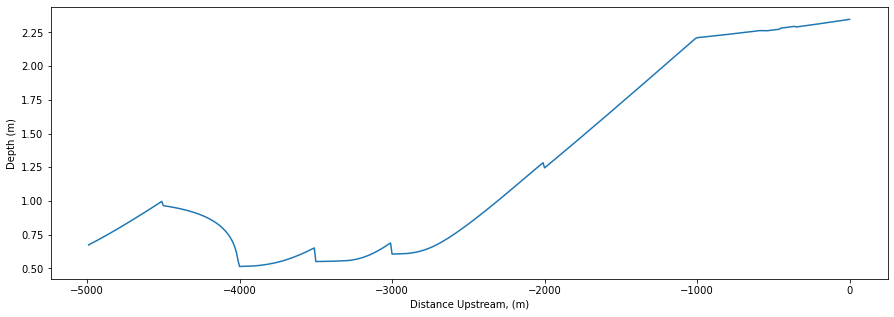

In [35]:
fig = plt.figure(1, figsize=(15,5))
plt.plot(x,h)
plt.xlabel('Distance Upstream, (m)')
plt.ylabel('Depth (m)')

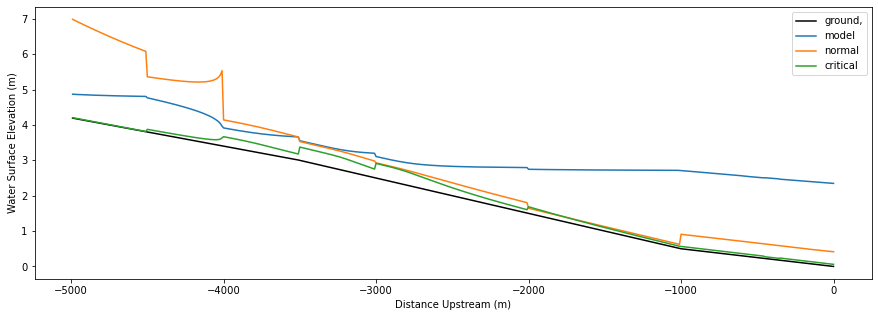

In [36]:
fig = plt.figure(1, figsize=(15,5))
plt.xlabel('Distance Upstream (m)')
plt.ylabel('Water Surface Elevation (m)')
WSE = [bedelev[i]+h[i] for i in range(len(x))]
cWSE = [bedelev[i]+hc[i] for i in range(len(x))]
nWSE = [bedelev[i]+hn[i] for i in range(len(x))]
plt.plot(x,bedelev,'k')
plt.plot(x,WSE)
plt.plot(x,nWSE)
plt.plot(x,cWSE)
#plt.legend(['model','normal','critical'])
plt.legend(['ground,','model','normal','critical'])

Text(0, 0.5, 'Discharge (m^3/s)')

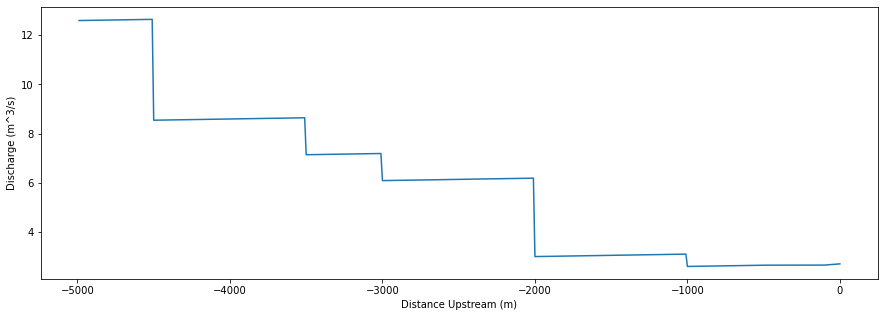

In [113]:
fig = plt.figure(1, figsize=(15,5))
plt.plot(x,Q)

plt.xlabel('Distance Upstream (m)')
plt.ylabel('Discharge (m^3/s)')

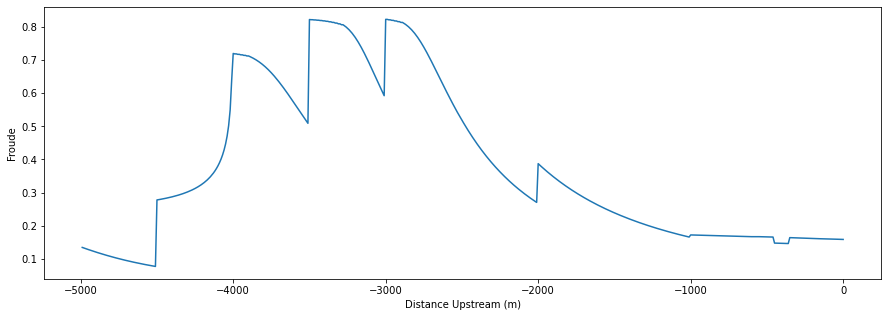

In [115]:
fig = plt.figure(1, figsize=(15,5))
plt.xlabel('Distance Upstream (m)')
plt.ylabel('Froude')
plt.plot(x,F1)

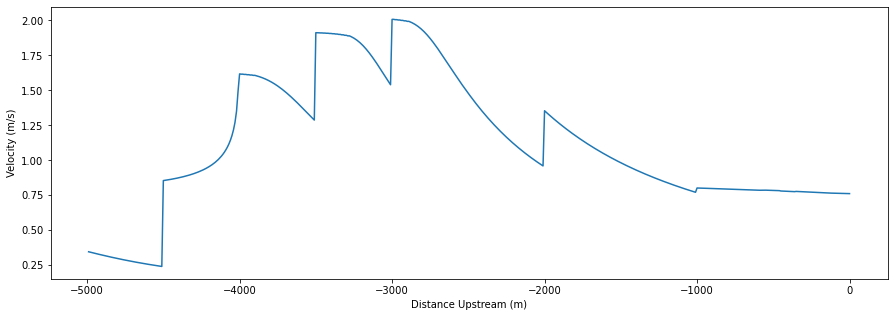

In [116]:
fig = plt.figure(1, figsize=(15,5))
plt.xlabel('Distance Upstream (m)')
plt.ylabel('Velocity (m/s)')
plt.plot(x,u)

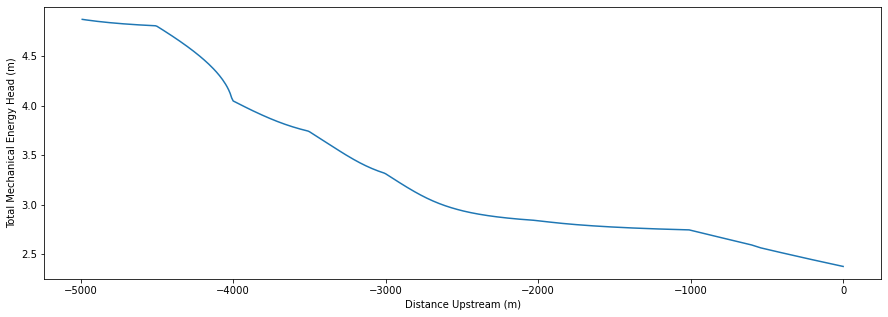

In [123]:
fig = plt.figure(1, figsize=(15,5))
plt.xlabel('Distance Upstream (m)')
plt.ylabel('Total Mechanical Energy Head (m)')
plt.plot(x,H)

In [ ]:
# create plot that shows flow rate as a function of position, if result merges on accurate solution
# calculate cross sectional averaged velocity
# calculate flow depth
# plot flow depth with hc and hn
# WSE
# Fr
# calculate total mechanical energy head
# calculate off-take flow rates

### Export inputs and outputs

In [191]:
d = {'x m':x,'dx m':dx,'bedelev m':bedelev,'n':n,'q m^/s':q,'alpha':alpha,'geo':geo,'structure':structure, 'So':So}
inputs = pd.DataFrame(data=d)

inputs.to_csv('inputs.csv')

In [37]:
h = [h[i] for i in range(len(x))]
H = [H[i] for i in range(len(x))]
A = [A[i] for i in range(len(x))]
R = [R[i] for i in range(len(x))]
P = [P[i] for i in range(len(x))]
u = [u[i] for i in range(len(x))]
S1 = [S1[i] for i in range(len(x))]
Q = [Q[i] for i in range(len(x))]
F1 = [F1[i] for i in range(len(x))]
WSE = [WSE[i] for i in range(len(x))]

d = {'h(m)':h,'H(m)':H,'A(m^2)':A,'R(m)':R,'P(m)':P,'u(m/s)':u,'Sf':S1,'Q':Q,'Fr':F1,'WSE':WSE}
outputs = pd.DataFrame(data=d)
outputs.to_csv('outputs.csv')